<a href="https://colab.research.google.com/github/Martindelosrios/CADDENA/blob/master/Example_O1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Example 1

Here we will learn how to use CADDENA for estimating the parameter posteriors given data from XENONnT experiment

# First let's install CADDENA from https://github.com/Martindelosrios/CADDENA

In [1]:
!git clone https://github.com/Martindelosrios/CADDENA.git

fatal: destination path 'CADDENA' already exists and is not an empty directory.


In [2]:
!pip install CADDENA/

Processing ./CADDENA
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for CADDENA: filename=CADDENA-0.1-py3-none-any.whl size=46383454 sha256=98267b7a85331a06ca05c1bf2757e7e72c27139d5c6a57229d3574f22a223f97
  Stored in directory: /tmp/pip-ephem-wheel-cache-als9jt8r/wheels/01/60/9c/3f898a50d94083c441ff62107d2069e78d898d67e9818b4ea4
Successfully built CADDENA
  Attempting uninstall: CADDENA
    Found existing installation: CADDENA 0.1
    Uninstalling CADDENA-0.1:
      Successfully uninstalled CADDENA-0.1


# Let's load the needed packages and data

In [3]:
from CADDENA import caddena, models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
import pkg_resources
from importlib_resources import files

from scipy.integrate import trapezoid
from matplotlib.lines import Line2D

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Using GPU


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [4]:
# Some fancy colour configuration
color_rate = "#d55e00"
color_drate = "#0072b2"
color_s1s2 = "#009e73"

In [5]:
# Now let's load the dataset with XENON nT simulations.
#  This data was create with .....

ref = files("CADDENA") / "dataset/"
DATA_PATH = str(ref)
with h5py.File(DATA_PATH + "/testset.h5", "r") as data:
  rate_testset = data['rate_testset'][()]
  drate_testset = data['drate_testset'][()]
  s1s2_testset = data['s1s2_testset'][()]
  pars_testset = data['pars_testset'][()]
  pars_min = data.attrs["pars_min"]
  pars_max = data.attrs["pars_max"]
  x_min_rate = data.attrs["x_min_rate"]
  x_max_rate = data.attrs["x_max_rate"]
  x_min_drate = data.attrs["x_min_drate"]
  x_max_drate = data.attrs["x_max_drate"]
  x_max_s1s2 = data.attrs["x_max_s1s2"]

In [6]:
pars_norm = (pars_testset - pars_min) / (pars_max - pars_min)

x_norm_rate = np.log10(rate_testset)
x_norm_rate = (x_norm_rate - x_min_rate) / (x_max_rate - x_min_rate)
x_norm_rate = x_norm_rate.reshape(len(x_norm_rate), 1)

x_norm_drate = np.log10(drate_testset)
x_norm_drate = (x_norm_drate - x_min_drate) / (x_max_drate - x_min_drate)

x_norm_s1s2 = (s1s2_testset)
x_norm_s1s2 = x_norm_s1s2 / x_max_s1s2


# Let's play with CADDENA!

In [7]:
# Let's pick some random synthetic observation from the simulated dataset.

i = np.random.randint(len(pars_norm))
print('nobs = ' + str(i))

pars_true   = pars_norm[i,:]
x_obs_rate  = x_norm_rate[i,:]
x_obs_drate = x_norm_drate[i,:]
x_obs_s1s2  = x_norm_s1s2[i,:].reshape(1,96,96)

M_DM_real = 10**(pars_true[0] * (pars_max[0] - pars_min[0]) + pars_min[0])
print('M_DM = {:.2f} GeV'.format(M_DM_real))
sigma_real = 10**(pars_true[1] * (pars_max[1] - pars_min[1]) + pars_min[1])
print('sigma = {:.3e} cm2'.format(sigma_real))
theta_real = (pars_true[2] * (pars_max[2] - pars_min[2]) + pars_min[2])
print('theta = {:.3} '.format(theta_real))

nobs = 554
M_DM = 24.91 GeV
sigma = 1.700e-46 cm2
theta = 1.54 


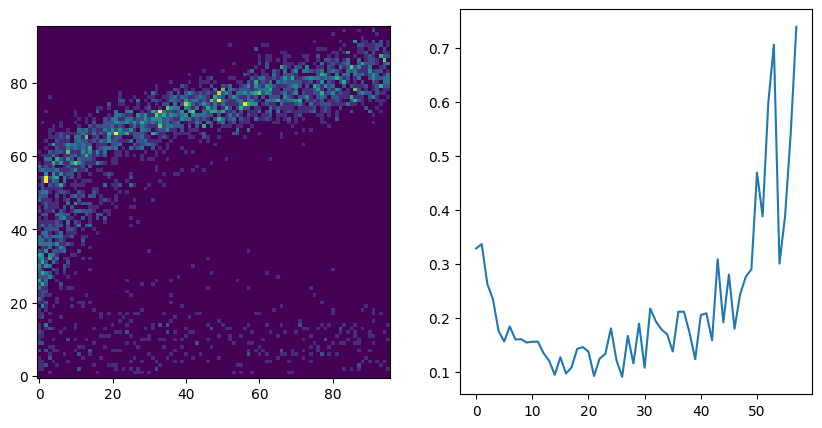

In [8]:
# Let's see how it looks

fig,ax = plt.subplots(1,2, figsize = (10,5))

ax[0].imshow(x_obs_s1s2.T, origin = 'lower')

ax[1].plot(x_obs_drate)

plt.show()

Now let's check the available models...

As you can see, when doing print(model) you have some information about the available models

In [9]:
# Now let's check the available models...

print('--------------------------------')
print('For analyzing s1s2 images we have:')

print(models.XENONnT_O1_s1s2)

print('--------------------------------')
print('For analyzing differential rate data we have:')

print(models.XENONnT_O1_drate)

print('--------------------------------')
print('For analyzing total rate data we have:')

print(models.XENONnT_O1_rate)

--------------------------------
For analyzing s1s2 images we have:

    XENONnT_O1_s1s2:

    This model was trained using synthetic data of the expected S1S2
    signal in xenonNT for dark matter particles with O(1)
    with :math:`M_{dm} in [6-1000] GeV`, :math:`sigma = [10^{-50}-10^{-43}] cm^{2}`
    and :math:`	heta = [-pi/2-pi/2]`.
    In order to analyse a new data x it must be a np.array with shape (n,1,97,70),
    where n is the number of observations to be analysed.

    You can extract the 1D marginal posteriors of each parameter or the 2D
    marginal posteriors of combination of parameters.

 NOT TRAINED 

--------------------------------
For analyzing differential rate data we have:

    XENONnT_O1_drate:

    This model was trained using synthetic data of the expected differential
    rate in xenonNT for dark matter particles with O(1)
    with :math:`M_{dm} in [6-1000] GeV`, :math:`sigma = [10^{-50}-10^{-43}] cm^{2}`
    and :math:`theta = [-pi/2-pi/2]`.
    In order to

As you can see, the models are not trained yet!!!
This can also be check individually for each model by doing:

```python
model.trained_flag
```

Anyway, as these models were pre-trained in arxiv XXXX.XXXX
you can load the saved weights just doing for a given model

```python
model.load_weights()
```



In [10]:
models.XENONnT_O1_rate.trained_flag

<bound method Model.trained_flag of 
    XENONnT_O1_rate:

    This model was trained using synthetic data of the expected total
    rate in xenonNT for dark matter particles with O(1)
    with :math:`M_{dm} \in [6-1000] GeV`, :math:`\sigma = [10^{-50}-10^{-43}] cm^{2}`
    and :math:`\theta = [-\pi/2-\pi/2]`.
    In order to analyse a new data x it must be a np.array with shape (n,1),
    where n is the number of observations to be analysed.

    You can extract the 1D marginal posteriors of each parameter or the 2D
    marginal posteriors of combination of parameters.

 NOT TRAINED 
>

In [11]:
models.XENONnT_O1_rate.load_weights()
models.XENONnT_O1_drate.load_weights()
models.XENONnT_O1_s1s2.load_weights()

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /usr/local/lib/python3.10/dist-packages/CADDENA/dataset/O1_rate.ckpt


Training model...
Reading weights from 

/usr/local/lib/python3.10/dist-packages/CADDENA/dataset/O1_rate.ckpt


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /usr/local/lib/python3.10/dist-packages/CADDENA/dataset/O1_rate.ckpt


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:749: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    32.742055819548405     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /usr/local/lib/python3.10/dist-packages/CADDENA/dataset/O1_drate.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /usr/local/lib/python3.10/dist-packages/CADDENA/dataset/O1_drate.ckpt


Training model...
Reading weights from 

/usr/local/lib/python3.10/dist-packages/CADDENA/dataset/O1_drate.ckpt


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/CADDENA/models.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(a["x"])


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    -1.4365784334425484    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /usr/local/lib/python3.10/dist-packages/CADDENA/dataset/O1_s1s2.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /usr/local/lib/python3.10/dist-packages/CADDENA/dataset/O1_s1s2.ckpt


Training model...
Reading weights from 

/usr/local/lib/python3.10/dist-packages/CADDENA/dataset/O1_s1s2.ckpt


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/CADDENA/models.py:208: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(a["x"])


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    -1.6661612944087785    │
└───────────────────────────┴───────────────────────────┘

In [12]:
models.XENONnT_O1_rate.trained_flag

<bound method Model.trained_flag of 
    XENONnT_O1_rate:

    This model was trained using synthetic data of the expected total
    rate in xenonNT for dark matter particles with O(1)
    with :math:`M_{dm} \in [6-1000] GeV`, :math:`\sigma = [10^{-50}-10^{-43}] cm^{2}`
    and :math:`\theta = [-\pi/2-\pi/2]`.
    In order to analyse a new data x it must be a np.array with shape (n,1),
    where n is the number of observations to be analysed.

    You can extract the 1D marginal posteriors of each parameter or the 2D
    marginal posteriors of combination of parameters.

 READY TO USE :) 
>

In [13]:
# Let's sample the parameters from a flat prior

pars_prior = np.random.uniform(low = 0, high = 1, size = (100_000, 3))

# As you can see, you need to specify the prior in the normalized space!
# This will be re-normalized to the corresponding physical values internally.

In [14]:
# Let's analyze the each type of data with the corresponding model

# The first argument is a list with the observation that will be analyzed.
# The second argument is the sample of paramters that will be paired with the observations.
# The third argument is a list with the models that will be used.

# The first element of the observation list will be analyzed with the first element of the model list, and so on.

logratios1D, logratios2D = caddena.ratio_estimation([x_obs_rate, x_obs_drate, x_obs_s1s2], pars_prior, [models.XENONnT_O1_rate, models.XENONnT_O1_drate, models.XENONnT_O1_s1s2])

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


0


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


1


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


2


Predicting: 0it [00:00, ?it/s]

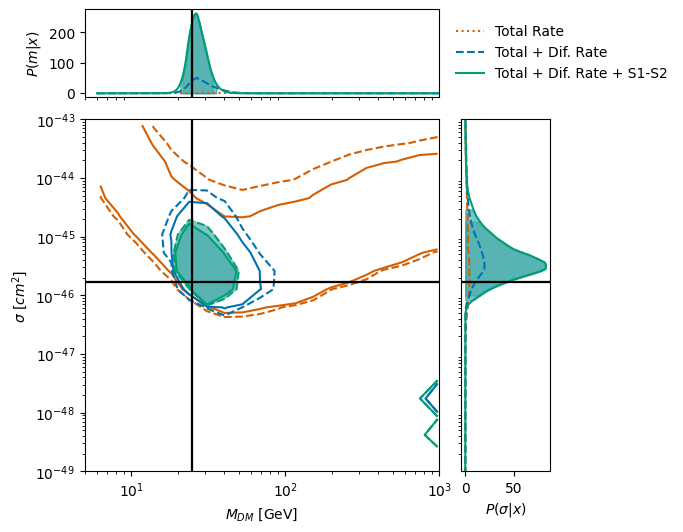

In [15]:
# Now let's make some plots to see the results


fig,ax = plt.subplots(2,2, figsize = (6,6),
                      gridspec_kw={'height_ratios': [0.5, 2], 'width_ratios':[2,0.5]})

plt.subplots_adjust(hspace = 0.1, wspace = 0.1)

caddena.plot1d([logratios1D[0]], pars_prior, pars_true, ax[0,0], par = 0, fill = False, linestyle = ':', color = color_rate, pars_min = pars_min, pars_max = pars_max)
caddena.plot1d([logratios1D[0], logratios1D[1]], pars_prior, pars_true, ax[0,0], par = 0, fill = False, linestyle = '--', color = color_drate, pars_min = pars_min, pars_max = pars_max)
caddena.plot1d(logratios1D, pars_prior, pars_true, ax[0,0], par = 0, fill = True, linestyle = 'solid', color = color_s1s2, pars_min = pars_min, pars_max = pars_max)

caddena.plot2d([logratios2D[0]], pars_prior, pars_true, ax[1,0], fill = False, line = True, linestyle = ':', color = color_rate, pars_min = pars_min, pars_max = pars_max)
caddena.plot2d([logratios2D[0],logratios2D[1]], pars_prior, pars_true, ax[1,0], fill = False, line = True, linestyle = '--', color = color_drate, pars_min = pars_min, pars_max = pars_max)
caddena.plot2d(logratios2D, pars_prior, pars_true, ax[1,0], fill = True, line = True, linestyle = 'solid', color = color_s1s2, pars_min = pars_min, pars_max = pars_max)

caddena.plot1d([logratios1D[2]], pars_prior, pars_true, ax[1,1], par = 1, flip = True, fill = False, linestyle = '--', color = color_rate, pars_min = pars_min, pars_max = pars_max)
caddena.plot1d([logratios1D[0], logratios1D[1]], pars_prior, pars_true, ax[1,1], par = 1, flip = True, fill = False, linestyle = '--', color = color_drate, pars_min = pars_min, pars_max = pars_max)
caddena.plot1d(logratios1D, pars_prior, pars_true, ax[1,1], par = 1, flip = True, fill = True, linestyle = 'solid', color = color_s1s2, pars_min = pars_min, pars_max = pars_max)

ax[0,0].set_xlim(5,1e3)
ax[1,0].set_xlim(5,1e3)
ax[1,0].set_ylim(1e-49,1e-43)
ax[1,1].set_ylim(1e-49,1e-43)

ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('$P(m|x)$')
ax[0,0].set_xticks([])
ax[1,1].set_ylabel('')
ax[1,1].set_yticks([])
ax[1,1].set_xlabel('$P(\sigma|x)$')

custom_lines = []
labels = ['Total Rate', 'Total + Dif. Rate', 'Total + Dif. Rate + S1-S2']
markers = [':','--', 'solid']
colors = [color_rate, color_drate, color_s1s2]
for i in range(3):
    custom_lines.append( Line2D([0],[0], linestyle = markers[i], color = colors[i],
            label = labels[i]) )

ax[0,1].axis('off')
ax[0,1].legend(handles = custom_lines, frameon = False, loc = 'lower left', bbox_to_anchor=(-0.2,0.05))

plt.show()